In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Best Parameters: {'max_depth': 10, 'min_samples_split': 10}

Cross-Validation Results:
Mean R²: 0.7846
Mean RMSE: 40.62
Mean MAE: 33.74


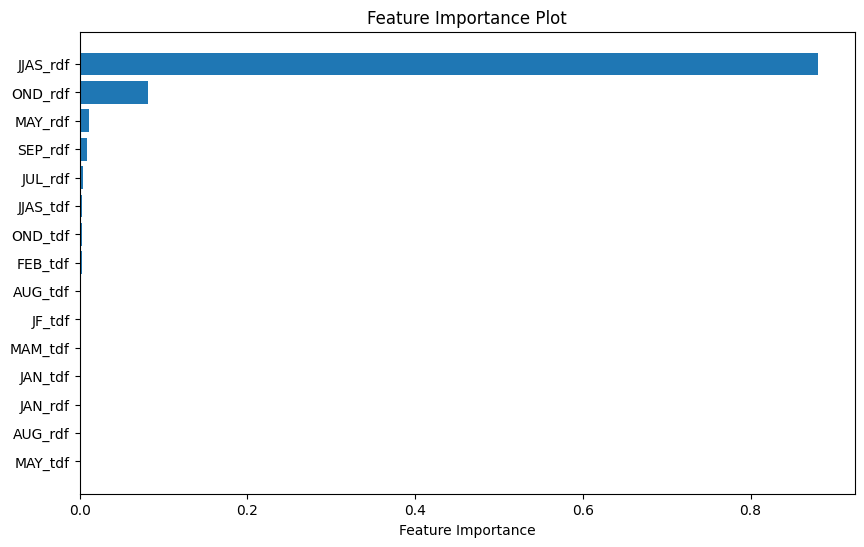


✅ Model saved as 'final_rainfall_predictor.pkl'.

Example Prediction for First Sample:
Predicted Annual Rainfall: 974.08 mm


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib

# 2. Load Data
rdf = pd.read_csv('/content/drive/MyDrive/rain/rainfalldata.xls - rainfalldata.xls.csv')
tdf = pd.read_csv('/content/drive/MyDrive/rain/annualdatamean.csv')

# 3. Rename Columns (if needed)
tdf = tdf.rename(columns={
    'ANNUAL': 'ANN',
    'JAN-FEB': 'JF',
    'MAR-MAY': 'MAM',
    'JUN-SEP': 'JJAS',
    'OCT-DEC': 'OND'
})

# 4. Merge on 'YEAR'
merged = pd.merge(tdf, rdf, on='YEAR', suffixes=('_tdf', '_rdf'))

# 5. Feature Selection
selected_features_tdf = ['OND_tdf', 'JF_tdf', 'FEB_tdf', 'JJAS_tdf', 'MAM_tdf', 'AUG_tdf', 'JAN_tdf', 'MAY_tdf']
selected_features_rdf = ['JJAS_rdf', 'OND_rdf', 'MAY_rdf', 'JUL_rdf', 'SEP_rdf', 'JAN_rdf', 'AUG_rdf']
X = merged[selected_features_tdf + selected_features_rdf]
y = merged['ANN_rdf']

# 6. Hyperparameter Tuning with GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10]
}

dtree = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dtree, param_grid, cv=10, scoring='r2', n_jobs=-1)
grid_search.fit(X, y)

# Best Model
best_model = grid_search.best_estimator_

print(f"Best Parameters: {grid_search.best_params_}")

# 7. Cross-validation Evaluation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

r2_scores, rmse_scores, mae_scores = [], [], []

for train_index, test_index in kfold.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    model = DecisionTreeRegressor(random_state=42,
                                  max_depth=grid_search.best_params_['max_depth'],
                                  min_samples_split=grid_search.best_params_['min_samples_split'])
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    r2_scores.append(r2_score(y_val, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    mae_scores.append(mean_absolute_error(y_val, y_pred))

print("\nCross-Validation Results:")
print(f"Mean R²: {np.mean(r2_scores):.4f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.2f}")
print(f"Mean MAE: {np.mean(mae_scores):.2f}")

# 8. Final Model Training on Full Data
final_model = DecisionTreeRegressor(
    random_state=42,
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split']
)
final_model.fit(X, y)

# 9. Feature Importance Plot
importances = final_model.feature_importances_
feature_names = X.columns

sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance Plot")
plt.gca().invert_yaxis()
plt.show()

# 10. Save the Model
joblib.dump(final_model, '/content/drive/MyDrive/rain/final_rainfall_predictor.pkl')

print("\n✅ Model saved as 'final_rainfall_predictor.pkl'.")

# 11. Predict Example
sample = X.iloc[[0]]
predicted_rainfall = final_model.predict(sample)
print(f"\nExample Prediction for First Sample:")
print(f"Predicted Annual Rainfall: {predicted_rainfall[0]:.2f} mm")